# M5 Forecasting - Accuracy
**Estimate the unit sales of Walmart retail goods**

**Задача** - провести анализ и следать предсказание продаж товаров на 28 дней вперед.

**Данные**

Мы работаем с 42840 иерархическими временными рядами. Данные получены в трех штатах США (Калифорния, Техас, Висконсин). Иерархические - значит что данные могут быть сгруппированы на различных уровнях: item, department, product category и штат. Информация о продажах собрана с июня 2011 по июнь 2016. В дополнение к числу продаж, нам также предоставлены соответствующие даты с ценами, промоакциями и праздниками. Также нас предупредили, что **большая часть временных рядов содержит нули**.

Данные содержат **3049** продуктов из 3 категорий и 7 отделов, проданных в 10 магазинах в трех штатах. Мы можем создать 1 временной ряд для всех продаж, 3 временных ряда по штатам и т.д. Самая большая категория - это продажи всех 3049 товаров в 10 магазинах что дает 30 390 временных рядов.

Данные содержатся в файлах:
- **calendar.csv** - содержит информацию о датах, на которые продавались товары
- **sales_train_validation.csv** - содержит исторические данные о продажах каждого продукта по магазинам [d_1 - d_1913]
- sample_submission.csv - формат файла для сабмишена
- **sell_prices.csv** - содержит информацию о стоимости продуктов проданных в каждом магазине в определенную дату
- sales_train_evaluation.csv - будет доступен за месяц до завершения соревнования. Содержит информацию о продажах [d_1 - d_1941]

**Метрика** - Weighted Root Mean Squared Scaled Error (RMSSE). Она вычисляется для каждого временного ряда и затем усредняется по всем рядам с весами, которые определяются пропорционально продажам конкретного товара в долларах, чтобы более значимыми были товары с высокими продажами. Веса определяются по последним 28 дням тренировочных данных (которые видимо предоставят за месяц до дедлайна)

## EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# функция оптимизирующая место занимаемое набором данных
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загружаем данные

In [6]:
# sales_df = pd.read_csv("../data/input/sales_train_validation.csv", index_col='id')
# prices_df = pd.read_csv("../data/input/sell_prices.csv", index_col='store_id')
# calendar_df = pd.read_csv("../data/input/calendar.csv", index_col='date')
# sample_submit = pd.read_csv("../data/input/sample_submission.csv", index_col='id')
sales_df = pd.read_csv("../data/input/sales_train_validation.csv")
prices_df = pd.read_csv("../data/input/sell_prices.csv")
calendar_df = pd.read_csv("../data/input/calendar.csv")
sample_submit = pd.read_csv("../data/input/sample_submission.csv")

In [7]:
sales_df = reduce_mem_usage(sales_df, True)
prices_df = reduce_mem_usage(prices_df, True)
calendar_df = reduce_mem_usage(calendar_df, True)
sample_submit = reduce_mem_usage(sample_submit, True)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%
Memory usage of dataframe is 13.49 MB
Memory usage after optimization is: 4.83 MB
Decreased by 64.2%


#### Продажи

Данные по количеству покупок каждого товара за каждый день за исследуемый период

In [8]:
def print_df_info(df):
    print(f"Shape of train data: {df.shape}")
    print(df.info())

In [9]:
print_df_info(sales_df)
sales_df.head()

Shape of train data: (30490, 1919)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.4 MB
None


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


- id - обозначает тоже самое, что в submission с той лишь разницей, что тут данные только для открытой части соревнования
- item_id - идентификатор товара (FOODS_3_629 - 629 товар 3-й подкатегории категории Еда)
- dept_id - идентификатор подкатегории
- cat_id - идентификатор категории
- store_id - идентификатор магазина
- state_id - идентификатор штата
- d_1..d_1913 - сведения о количестве товаров купленных по каждому товару за каждый день

#### Цены товаров

In [10]:
print_df_info(prices_df)
prices_df.head()

Shape of train data: (6841121, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      category
item_id       category
wm_yr_wk      int16
sell_price    float16
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB
None


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


- store_id - идентификатор магазина (включает наименование штата)
- item_id - идентификатор продукта (включает категорию и подкатегорию товара)
- wm_yr_wk - номер недели
- sell_price - цена товара в данном магазине на данной неделе

#### Календарь

Описывает данные о событиях по каждой дате

In [11]:
print_df_info(calendar_df)
calendar_df.head()

Shape of train data: (1969, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null category
wm_yr_wk        1969 non-null int16
weekday         1969 non-null category
wday            1969 non-null int8
month           1969 non-null int8
year            1969 non-null int16
d               1969 non-null category
event_name_1    162 non-null category
event_type_1    162 non-null category
event_name_2    5 non-null category
event_type_2    5 non-null category
snap_CA         1969 non-null int8
snap_TX         1969 non-null int8
snap_WI         1969 non-null int8
dtypes: category(7), int16(2), int8(5)
memory usage: 227.8 KB
None


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


- date - дата
- wm_yr_wk - номер недели
- weekday - день недели
- wday - номер дня недели
- month - номер месяца
- year - год
- d - номер дня
- event_name_1 - имя события, если оно происходило в этот день
- event_type_1 - тип события, если оно происходило в этот день
- event_name_2 - имя события 2, если оно происходило в этот день
- event_type_2 - тип события 2, если оно происходило в этот день
- snap_CA, snap_TX, snap_WI - (SNAP - программа помощи в питании) - показывает было ли в этот день по этому штату распределение пособия по питанию

#### Образец сабмишена

In [12]:
print_df_info(sample_submit)
sample_submit.head()

Shape of train data: (60980, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
id     60980 non-null category
F1     60980 non-null int8
F2     60980 non-null int8
F3     60980 non-null int8
F4     60980 non-null int8
F5     60980 non-null int8
F6     60980 non-null int8
F7     60980 non-null int8
F8     60980 non-null int8
F9     60980 non-null int8
F10    60980 non-null int8
F11    60980 non-null int8
F12    60980 non-null int8
F13    60980 non-null int8
F14    60980 non-null int8
F15    60980 non-null int8
F16    60980 non-null int8
F17    60980 non-null int8
F18    60980 non-null int8
F19    60980 non-null int8
F20    60980 non-null int8
F21    60980 non-null int8
F22    60980 non-null int8
F23    60980 non-null int8
F24    60980 non-null int8
F25    60980 non-null int8
F26    60980 non-null int8
F27    60980 non-null int8
F28    60980 non-null int8
dtypes: category(1), int8(28)
memory usage: 4.8 MB
None


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


id - HOBBIES_2_004_WI_1 - говорит о том, что это 4 позиция товара 2-й подкатегории товаров категории "Хобби" в 1-м магазине штата WI
validation - значит, что данный id необходимо использовать для предсказаний открытой части соревнования - прогноз с 1914 по 1941 день
evaluation - значит, что данный id необходимо использовать для предсказаний закрытой части соревнования - прогноз с 1942 по 1969 день
F1 - F28 - 28 дней по которым необходимо предсказать количество покупок данного товара

In [13]:
sample_submit[sample_submit.id.apply(lambda r: r.endswith('validation'))].shape, \
sample_submit[sample_submit.id.apply(lambda r: r.endswith('evaluation'))].shape, 

((30490, 29), (30490, 29))

### Анализируем таблицу с продажами

Графики временных рядов по штатам

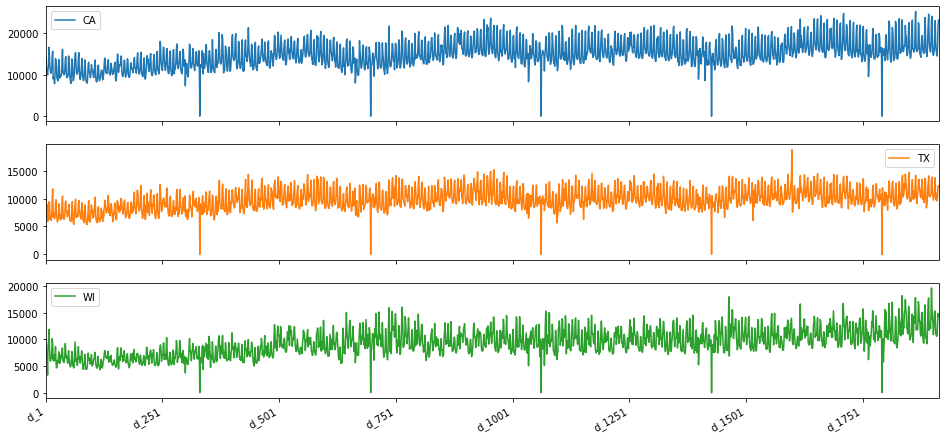

In [18]:
sales_df.groupby('state_id').sum().T.plot(subplots=True, figsize=(16, 8));

Графики временных рядов по магазинам

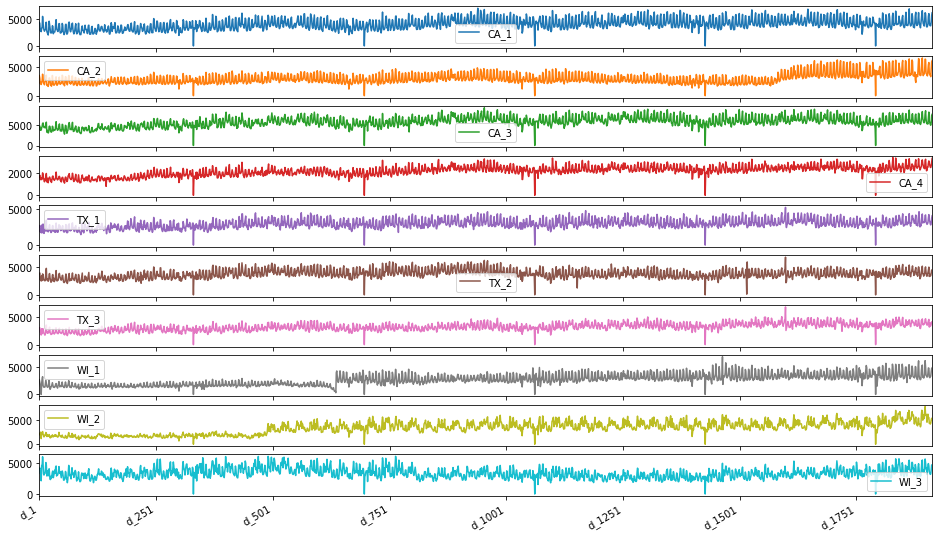

In [19]:
sales_df.groupby('store_id').sum().T.plot(subplots=True, figsize=(16, 10));

Графики временных рядов по категориям товаров за первые 50 дней

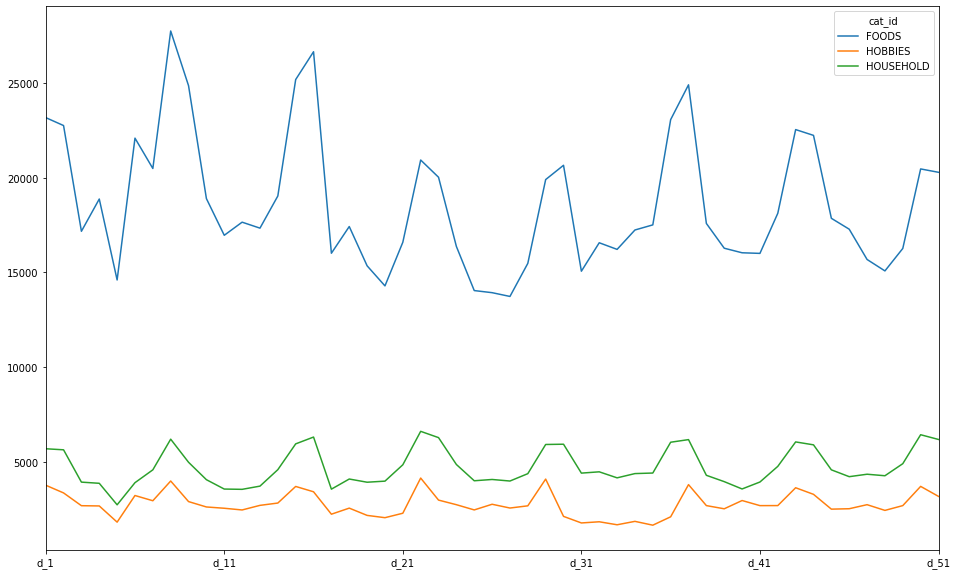

In [20]:
sales_df.groupby('cat_id').sum().loc[:,'d_1':'d_51'].T.plot(subplots=False, figsize=(16, 10));

In [22]:
sales_df['sum_for_peariod'] = sales_df.iloc[:, 6:].sum(axis=1)

In [23]:
sales_df.groupby('store_id')['sum_for_peariod'].describe()

,count,mean,std,min,25%,50%,75%,max
store_id,,,,,,,,
CA_1,3049.0,5049.666120,10704.080287,42.0,982.0,2244.0,4892.0,254406.0
CA_2,3049.0,3729.403083,6582.205864,24.0,712.0,1716.0,4108.0,126832.0
CA_3,3049.0,7338.917678,16960.460839,20.0,1194.0,2950.0,6944.0,501004.0
CA_4,3049.0,2691.817645,4828.854612,38.0,516.0,1288.0,2832.0,104528.0
TX_1,3049.0,3670.247294,8974.369986,56.0,592.0,1358.0,3278.0,224908.0
TX_2,3049.0,4732.295179,12845.862246,48.0,830.0,1818.0,4176.0,385670.0
TX_3,3049.0,3994.312889,10884.375014,32.0,646.0,1446.0,3572.0,300244.0
WI_1,3049.0,3377.541489,6040.318486,56.0,738.0,1694.0,3700.0,157986.0
WI_2,3049.0,4292.562807,9227.452192,32.0,586.0,1500.0,3938.0,139932.0


In [24]:
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].min()]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
6682,HOUSEHOLD_1_020_CA_3_validation,HOUSEHOLD_1_020,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,20


In [25]:
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].max()]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,...,160,204,86,100,88,77,141,139,130,501004


In [26]:
sales_df.groupby('cat_id').sum_for_peariod.sum()

cat_id
FOODS        90179878
HOBBIES      12249600
HOUSEHOLD    28961340
Name: sum_for_peariod, dtype: int64

In [27]:
sales_df.groupby(['cat_id', 'store_id']).sum_for_peariod.agg([min, max, np.mean, np.std])

min     max          mean           std
cat_id    store_id                                         
FOODS     CA_1      112  254406   7488.974252  14478.362646
          CA_2       24  126832   4843.784273   8571.246341
          CA_3       80  501004  10460.389701  22708.168153
          CA_4       58  104528   3924.043145   6161.076628
          TX_1       64  224908   5258.467641  12115.264290
          TX_2       48  385670   6979.991649  17896.354828
          TX_3       32  300244   5794.137787  15018.090541
          WI_1      126  157986   4785.458594   7875.121938
          WI_2       32  139932   6636.303410  12071.618328
          WI_3       76  242868   6584.105776  15136.646897
HOBBIES   CA_1       42   45488   3103.284956   5800.447895
          CA_2       62   27914   2257.709735   3801.048911
          CA_3       64   59484   3401.582301   6291.140190
          CA_4       48   28938   1998.070796   4153.270475
          TX_1       56   15296   1518.881416   2288.098544
          TX_2       98   20054   2251.316814   3034.543237
          TX_3       62   22582   1866.400000   2699.636795
          WI_1       56   27522   2321.047788   4054.843351
          WI_2       50   17392   1310.492035   2049.355261
          WI_3       26   15632   1651.922124   2577.017542
HOUSEHOLD CA_1       42   29208   2752.072588   3527.989116
          CA_2       96   31904   2994.103152   3766.027479
          CA_3       20   86702   5179.451767   9084.528086
          CA_4       38   12742   1374.968481   1566.132675
          TX_1       56   39758   2651.382999   4832.655531
          TX_2       88   38086   2986.175740   4782.504657
          TX_3       74   46642   2672.366762   4796.245943
          WI_1       70   21762   2015.308500   2669.725584
          WI_2       46   58966   2685.031519   5554.583806
          WI_3       50   33824   2350.399236   4211.442439

Используем календарь для анализа данных с учетом различных событий

In [28]:
sales_df.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
1640,FOODS_1_030_CA_1_validation,FOODS_1_030,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,2,0,0,1,1,2,1,1,1,2042
11083,FOODS_2_110_CA_4_validation,FOODS_2_110,FOODS_2,FOODS,CA_4,CA,0,0,0,0,...,2,2,0,0,0,3,2,4,4,1692
29231,FOODS_1_182_WI_3_validation,FOODS_1_182,FOODS_1,FOODS,WI_3,WI,0,0,0,0,...,0,3,1,1,4,3,0,1,3,3218
21712,HOBBIES_1_378_WI_1_validation,HOBBIES_1_378,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,...,1,2,1,2,1,1,0,0,1,3152
26867,FOODS_3_251_WI_2_validation,FOODS_3_251,FOODS_3,FOODS,WI_2,WI,0,0,0,0,...,0,1,2,0,0,0,0,0,0,816


In [29]:
sales_df.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
6256,HOBBIES_1_163_CA_3_validation,HOBBIES_1_163,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1434
8214,FOODS_2_290_CA_3_validation,FOODS_2_290,FOODS_2,FOODS,CA_3,CA,0,0,0,0,...,0,0,2,0,1,2,0,1,2,1494
5828,FOODS_3_555_CA_2_validation,FOODS_3_555,FOODS_3,FOODS,CA_2,CA,27,17,10,12,...,30,25,24,22,15,18,18,23,36,62002
9428,HOBBIES_1_289_CA_4_validation,HOBBIES_1_289,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,1,...,2,0,0,0,0,0,0,0,0,590
14347,FOODS_2_325_TX_1_validation,FOODS_2_325,FOODS_2,FOODS,TX_1,TX,0,0,0,0,...,0,0,0,2,0,2,0,0,1,6604
